## Setup

So first we need to import some libraries

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

The following library is one that we wrote ourselves. It just contains the basic code that makes up our model of cells and proteins as monomers with binding sites

In [126]:
from monomers import *

Now we define a couple of functions to set up an experiment.

### functions to initialize an experiment

In [3]:
def init_monomers(n_cells, n_proteins, n_cell_binding = 30, n_protein_binding = 4):
    '''instantiates a certain number of monomers'''
    Cell.n_cells=0
    cells=[]
    for i in range(n_cells):
        cells.append(Cell(n_cell_binding))

    Protein.n_proteins=0
    proteins=[]
    for i in range(n_proteins):
        proteins.append(Protein(n_protein_binding))
    return cells, proteins

After we set our monomers in place we need to modell in some way how they interact with each other. The following "polymerize" function does so in a very basic fashion:
* make a list of free binding sites of TP as well as cells
* while there are still free binding sites of either kind choose two at random and let them bind together

In [4]:
def polymerize(cells, proteins):
    '''polymerizes cells and proteins in a simple way'''
    free_cell_bindings = []
    for c in cells:
        free_cell_bindings += c.free_bindings

    free_protein_bindings = []
    for p in proteins:
        free_protein_bindings += p.free_bindings

    while len(free_protein_bindings)>0 and len(free_cell_bindings)>0:
        p_binding_idx = np.random.randint(len(free_protein_bindings))
        p_binding = free_protein_bindings.pop(p_binding_idx)
        c_binding_idx = np.random.randint(len(free_cell_bindings))
        c_binding = free_cell_bindings.pop(c_binding_idx)
        p_binding.bind(c_binding)
    return len(free_protein_bindings) , len(free_cell_bindings)

As described in the text above this simulation of polymerization was too simplified. The results we got from this modell were not very surprising and didn't help us much with optimizing our process.

So next we implemented a more sophisticated way of simulating the polymerization process. The following function takes some basic spacial and temporal effects into account.

In [49]:
def polymerize_spacial(cells, proteins, n_protein_binding, concentration=0.01, reactivity=0.2, mobility=0.05, max_time=10.):
    '''simulates polymerization in a more sophisticated way'''
    time = 0.
    position_variance = 1.
    distance_binding_probability = lambda x: np.exp(-x ** 2 / position_variance ** 2) / (
    2 * np.pi * position_variance ** 2)

    free_protein_bindings = []
    for p in proteins:
        free_protein_bindings += p.free_bindings

    while (time < max_time):
        # at each timestep a certain fraction of the free binding sites will have a chance to react
        # this fraction is depending on the defined "reactivity" parameter
        for i in range(int(np.ceil(reactivity * len(free_protein_bindings)))):
            # choose a random NPBS
            p_binding_idx = np.random.randint(len(free_protein_bindings))
            p_binding = free_protein_bindings[p_binding_idx]
            
            # do tests on parent protein
            p = p_binding.parent
            # all monomers get assigned an individual increasing id at creation
            # we use this id to calculate a position by assuming
            # that at creation the cells are put on a line with equal distance to echa other
            
            # the lower to concentration, the higher the distance
            p_pos = float(p.id) / (len(proteins) * concentration)
            # (float) idx of nearest cell
            c_id_mean = p_pos * len(cells) * concentration
            # max distance of reachable cells from nearest cell
            max_range = position_variance * 3.2
            c_id_range = max_range * len(cells) * concentration
            c_id_min = max(int(c_id_mean - c_id_range), 0)
            c_id_max = min(int(c_id_mean + c_id_range), len(cells))
            # now we can calculate the cells in range
            candidate_cells = cells[c_id_min:c_id_max]

            if len(candidate_cells) == 0:
                #if there are no cells in reach we are done here and pic the next random NPBS to try again
                continue
            # otherwise we go on
            # now depending on the individual cells distance to the NP
            # we calculate the probability of each candidate cell to bind as a gaussian pdf of the distance
            min_distance = max(p_pos - position_variance * 3.2, 0) - p_pos
            max_distance = min(-p_pos + position_variance * 3.2,
                               len(proteins) - 1 / len(proteins) / concentration) + p_pos
            probabilities = np.arange(min_distance, max_distance,
                                      (max_distance - min_distance) / len(candidate_cells))[:len(candidate_cells)]
            probabilities = distance_binding_probability(probabilities)
            probabilities /= sum(probabilities) #normalization
            
            # this call picks a random cell based on the calculated probabilities
            cell = np.random.choice(candidate_cells, p=probabilities)
            
            # check if the chosen cell has actually still free binding sites
            try:
                cell.free_bindings.next()
            except StopIteration:
                # no free bindings left in this cell. back to the top.
                continue
                
            # now we find out which cells the TP in question is already bound to
            protein_partners = list(set([b.partner.parent for b in p.bindings if b.partner is not None]))
            #this way we know how many different cells it's bound to
            if len(protein_partners) == 1:
                # if a protein is already attatched to a cell it will most likely not bind to other cells
                # but there is a chance of 10%
                if cell not in protein_partners and np.random.rand()<0.9:
                    continue
            if len(protein_partners)>1 and cell not in protein_partners:
                # if a protein was binding to two cells already, it will not bind to any other
                continue
            # if we made it this far without running into any of the "continue"s we are ready to bind!
            # so the next free binding of the cell will react to our NPBS
            cell.free_bindings.next().bind(p_binding)
            # and the TPBS is removed from our binding sites dating database
            free_protein_bindings.pop(p_binding_idx)
        
        # after all reactive NPBS tired to react we move everything a bit
        # depending on the mobility parameter and increment the time
        position_variance += mobility
        time += 0.01

    # in the end we calculate the number of free CBS. Just to know about it.
    free_cell_bindings = []
    for c in cells:
        free_cell_bindings += c.free_bindings
    return len(free_protein_bindings), len(free_cell_bindings)


## Analysis

Now for analyzing the generated polymer networks we import another library called graph_tool. 

In [11]:
from graph_tool.all import *

from graph_tool import clustering,stats

The following two functions translate the network (or graph) that we build before into graph_tool-graphs. The first one draws a node for each cell. Then it draws a connecting edge betwee two nodes if the respective cells are connected via any NP.

The second one draws a big node for each cell and a small one for each NP. Edges represent a binding between a NP and a connected cell. 

We will clarify the difference between the two graphing methods graphically after the two function definitions.

In [127]:
def cell_graph(cells,proteins,draw=False):
    '''vertices are cells, cells connected via a protein are connected in the graph with an edge'''
    g = Graph(directed=False)

    vertices = list(g.add_vertex(len(cells)))

    for c_id in range(len(cells)):
        for c_b in cells[c_id].bindings:
            try:
                for p_b in c_b.partner.parent.bindings:
                    try:
                        c2_id = p_b.partner.parent.id
                        if not c_id==c2_id:
                            g.add_edge(vertices[c_id],vertices[c2_id])
                    except AttributeError:
                        pass
            except AttributeError:
                pass
    if draw:
        graph_draw(g, vertex_text=g.vertex_index, edge_pen_width=2 , vertex_font_size=30, output="/tmp/graph.png",
            output_size=(2000, 2000))
    return g

In [128]:
def pc_graph(cells, proteins, draw=False):
    g = Graph(directed=False)

    v_size = g.new_vertex_property("int")

    for cell in cells:
        cell.vertex = g.add_vertex()
        v_size[cell.vertex] = 120

    for p in proteins:
        p.vertex=g.add_vertex()
        v_size[p.vertex] = 40
        for b in p.bindings:
            #cell connections
            if b.partner is not None:
                cell_vertex = b.partner.parent.vertex
                if g.edge(p.vertex,cell_vertex) is None: #only one connection per pair
                    g.add_edge(p.vertex,cell_vertex)
    if draw:
        pos=fruchterman_reingold_layout(g)
        graph_draw(g, edge_pen_width=2, vertex_text=g.vertex_index, vertex_size=v_size, vertex_font_size=15, output_size=(2000, 2000))
    return g

To make the difference more clear lets just run an experiment and visualize the result in both ways

In [133]:
cells, proteins = init_monomers(n_cells=30, n_proteins=200, n_cell_binding = 300, n_protein_binding = 4)
polymerize_spacial(cells, proteins, n_protein_binding=4, 
                   concentration=0.02, reactivity=0.1, mobility=0.05, max_time=3.0)

(2, 8202)

The experiment is done. Now let's visualize it

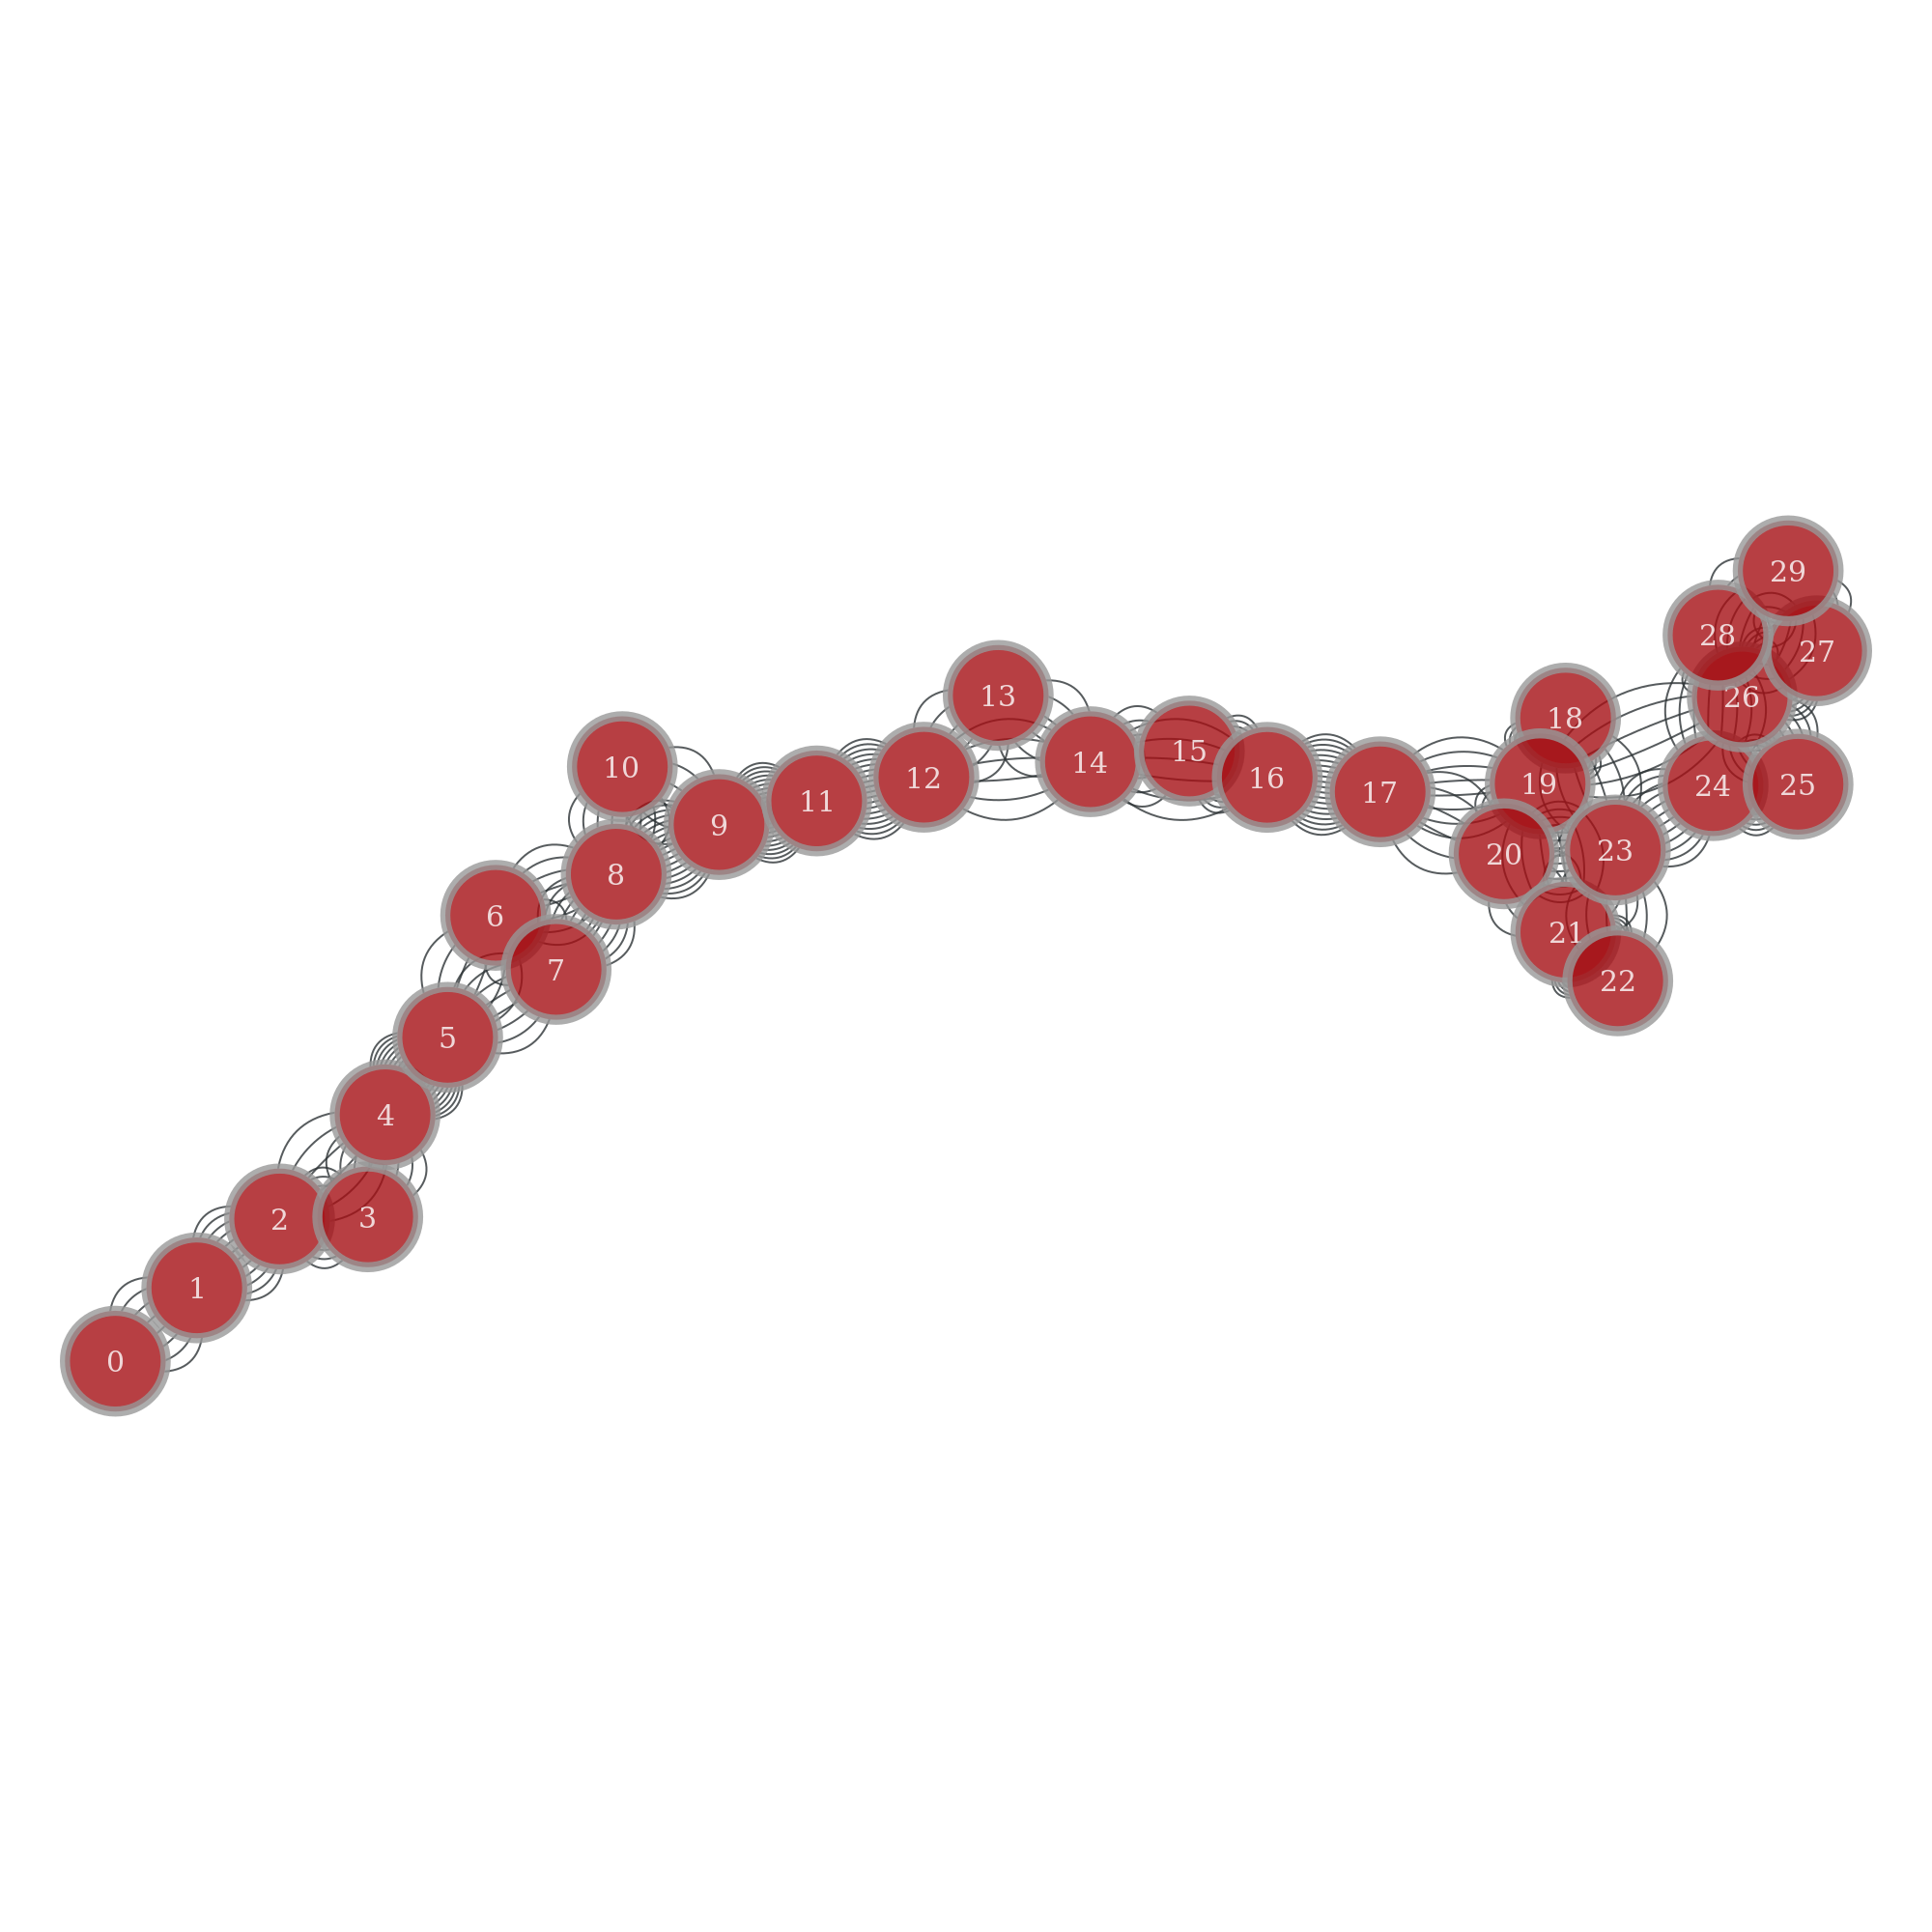

<Graph object, undirected, with 30 vertices and 492 edges at 0x7f6ef3edaed0>

In [141]:
cell_graph(cells,proteins,draw=True)

And now the same experimental result with the other visualization

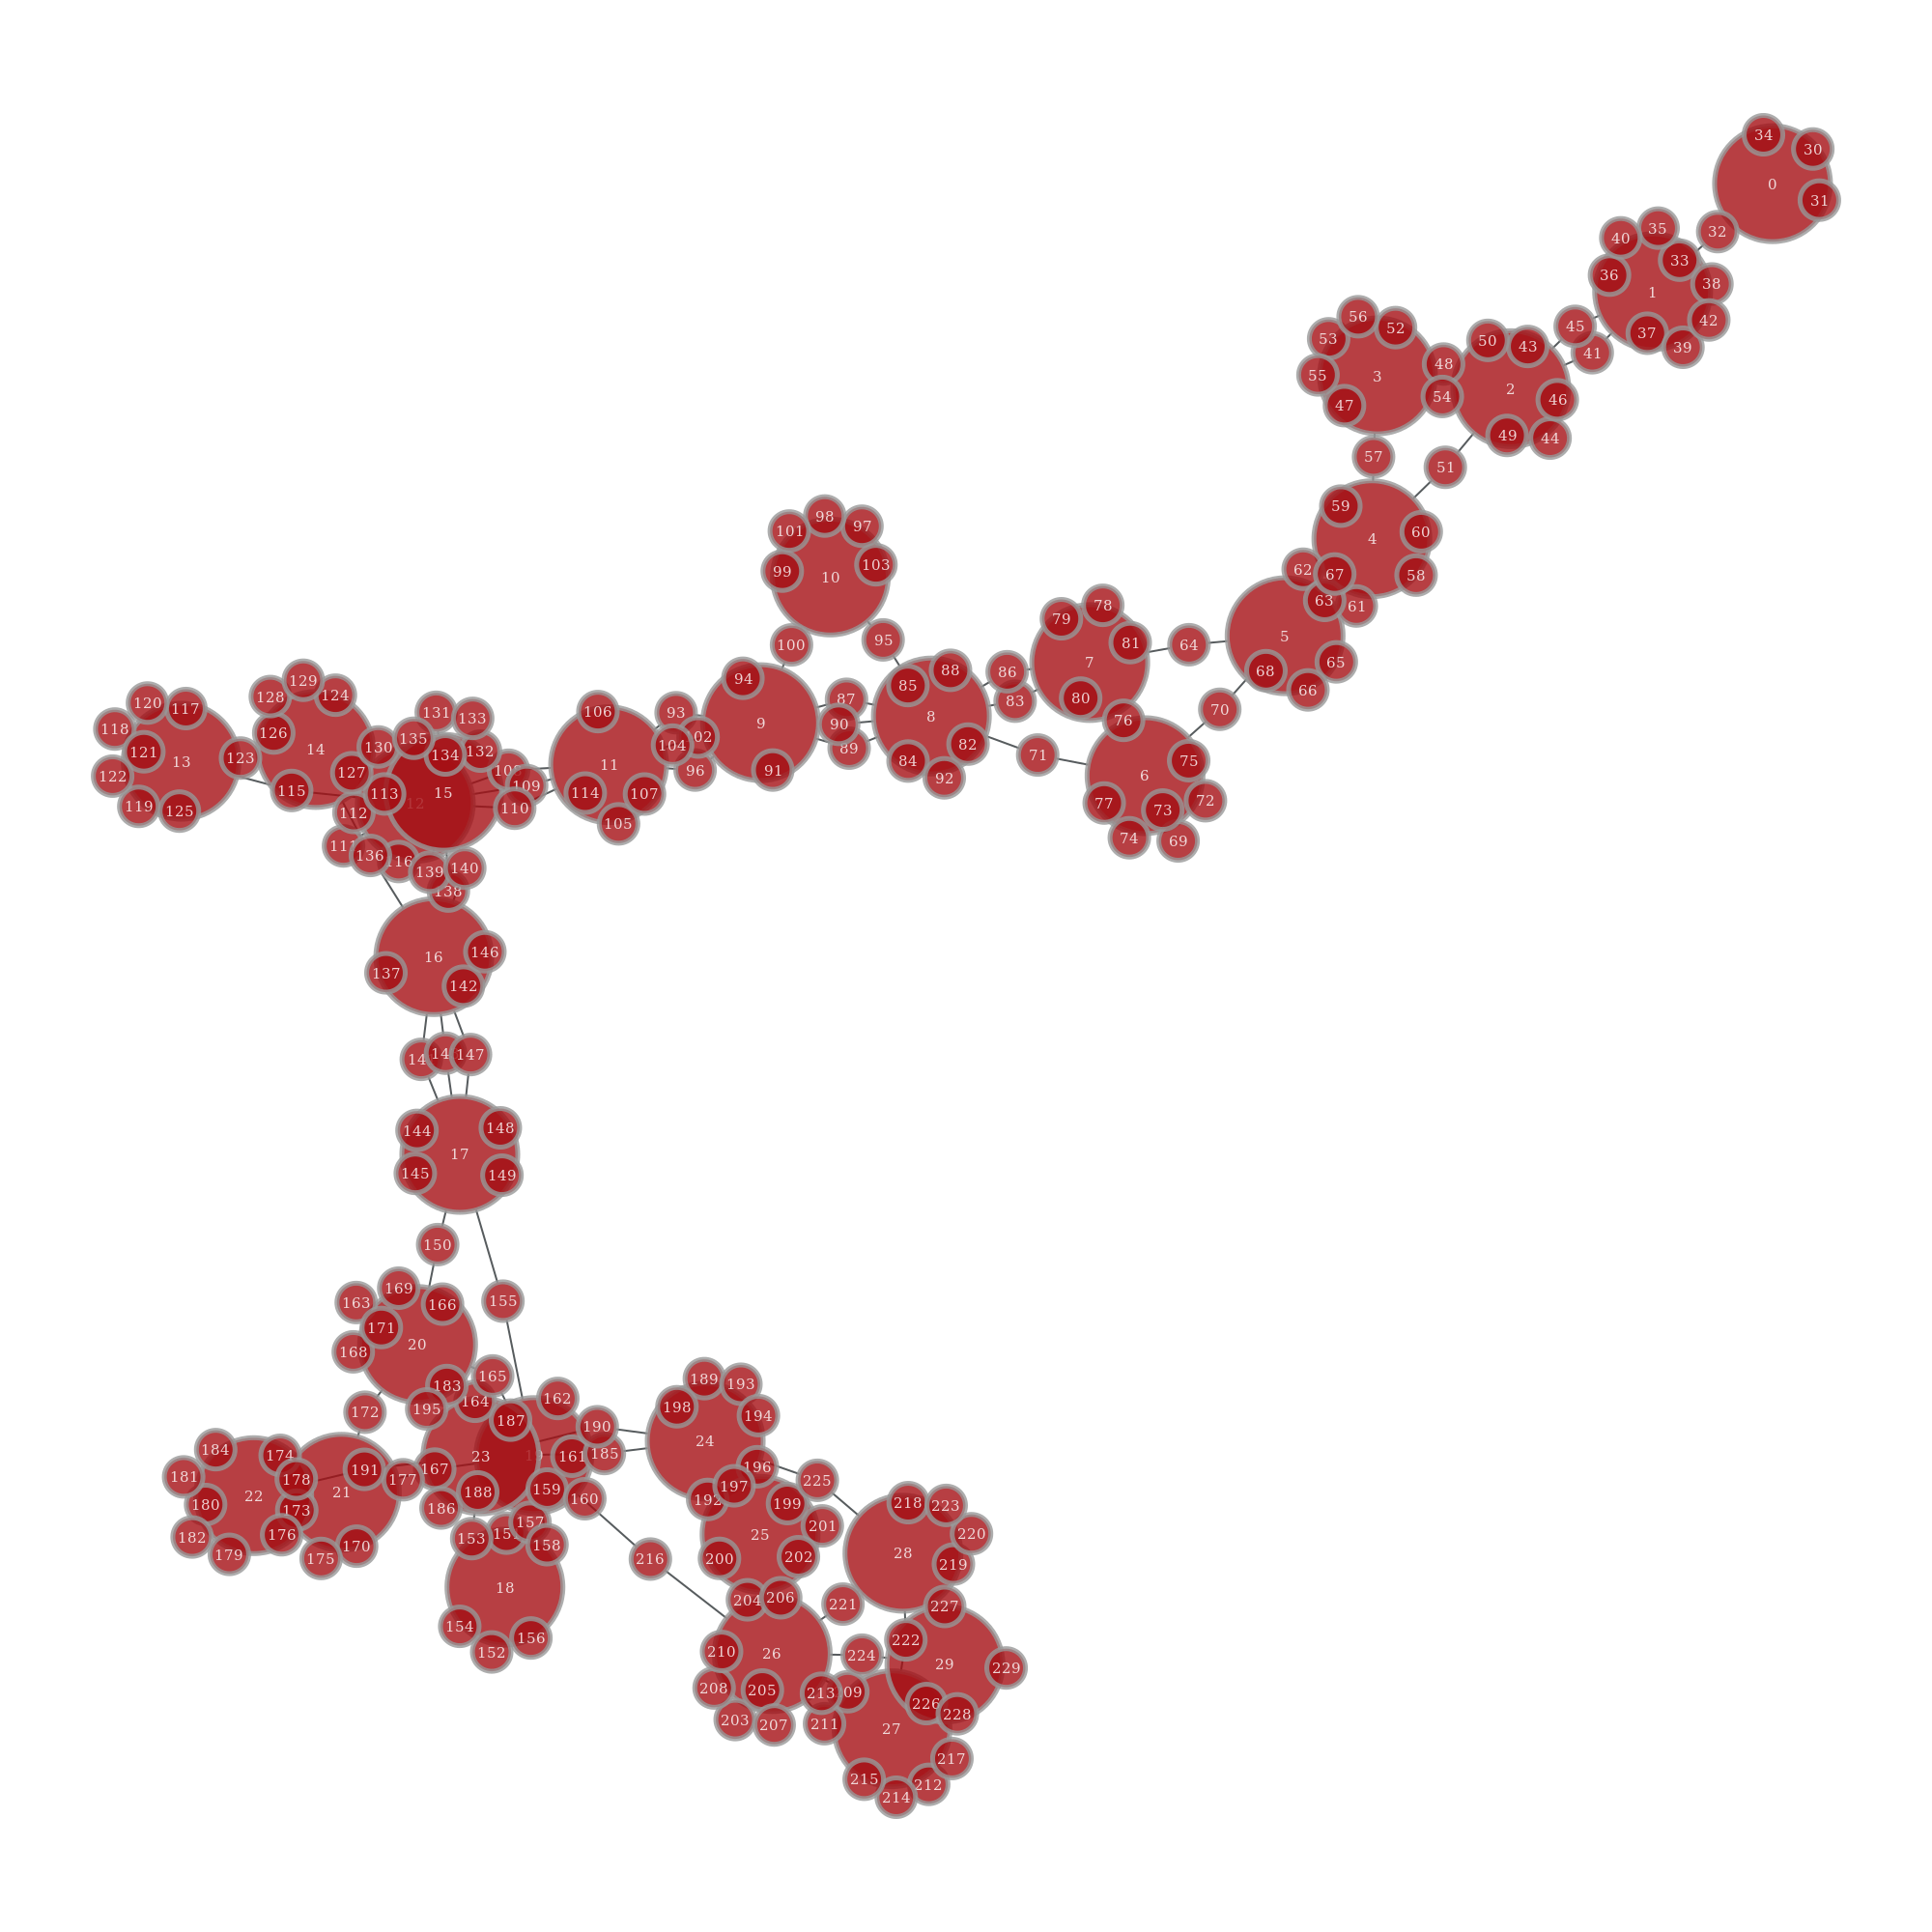

<Graph object, undirected, with 230 vertices and 276 edges at 0x7f6ef30f4110>

In [142]:
pc_graph(cells,proteins,draw=True)

The second graph shows not only how the interconnection between the idnividual cells is but also visualizes how many NP are "lost" by just sticking to a single cell without forming an connection to others. Furthermore one can see how many differnt proteins connect two cells.

### More experiments

For a first feeling of how the parameters of the polymerization function influence the result it's helpful just to try out a few combinations and look at the visualization of the graph

To make this task a bit easier we defien a small helper function that initializes the monomers, polymerizes them and generates the graph.

In [144]:
def random_graph(graph_method, n_cells, n_proteins, n_cell_binding = 30, n_protein_binding = 4,concentration=0.02,reactivity=0.01,mobility=0.1,max_time=2.):
#    cells,proteins=init_monomers(n_cells, n_proteins, n_cell_binding, n_protein_binding)
#    polymerize(cells,proteins)
    cells,proteins=init_monomers(n_cells, n_proteins, n_cell_binding = n_cell_binding, n_protein_binding = n_protein_binding)
    polymerize_spacial(cells, proteins, n_protein_binding=n_protein_binding, concentration=concentration, reactivity=reactivity, mobility=mobility, max_time=max_time)
    return graph_method(cells,proteins,draw),cells,proteins

As long as we want to see a rendered result we just switch the draw variable to True

In [145]:
draw = True

Now we can build a random graph by plugging in some numbers and runnign a single line of code. (The "_=" just suppresses text output)

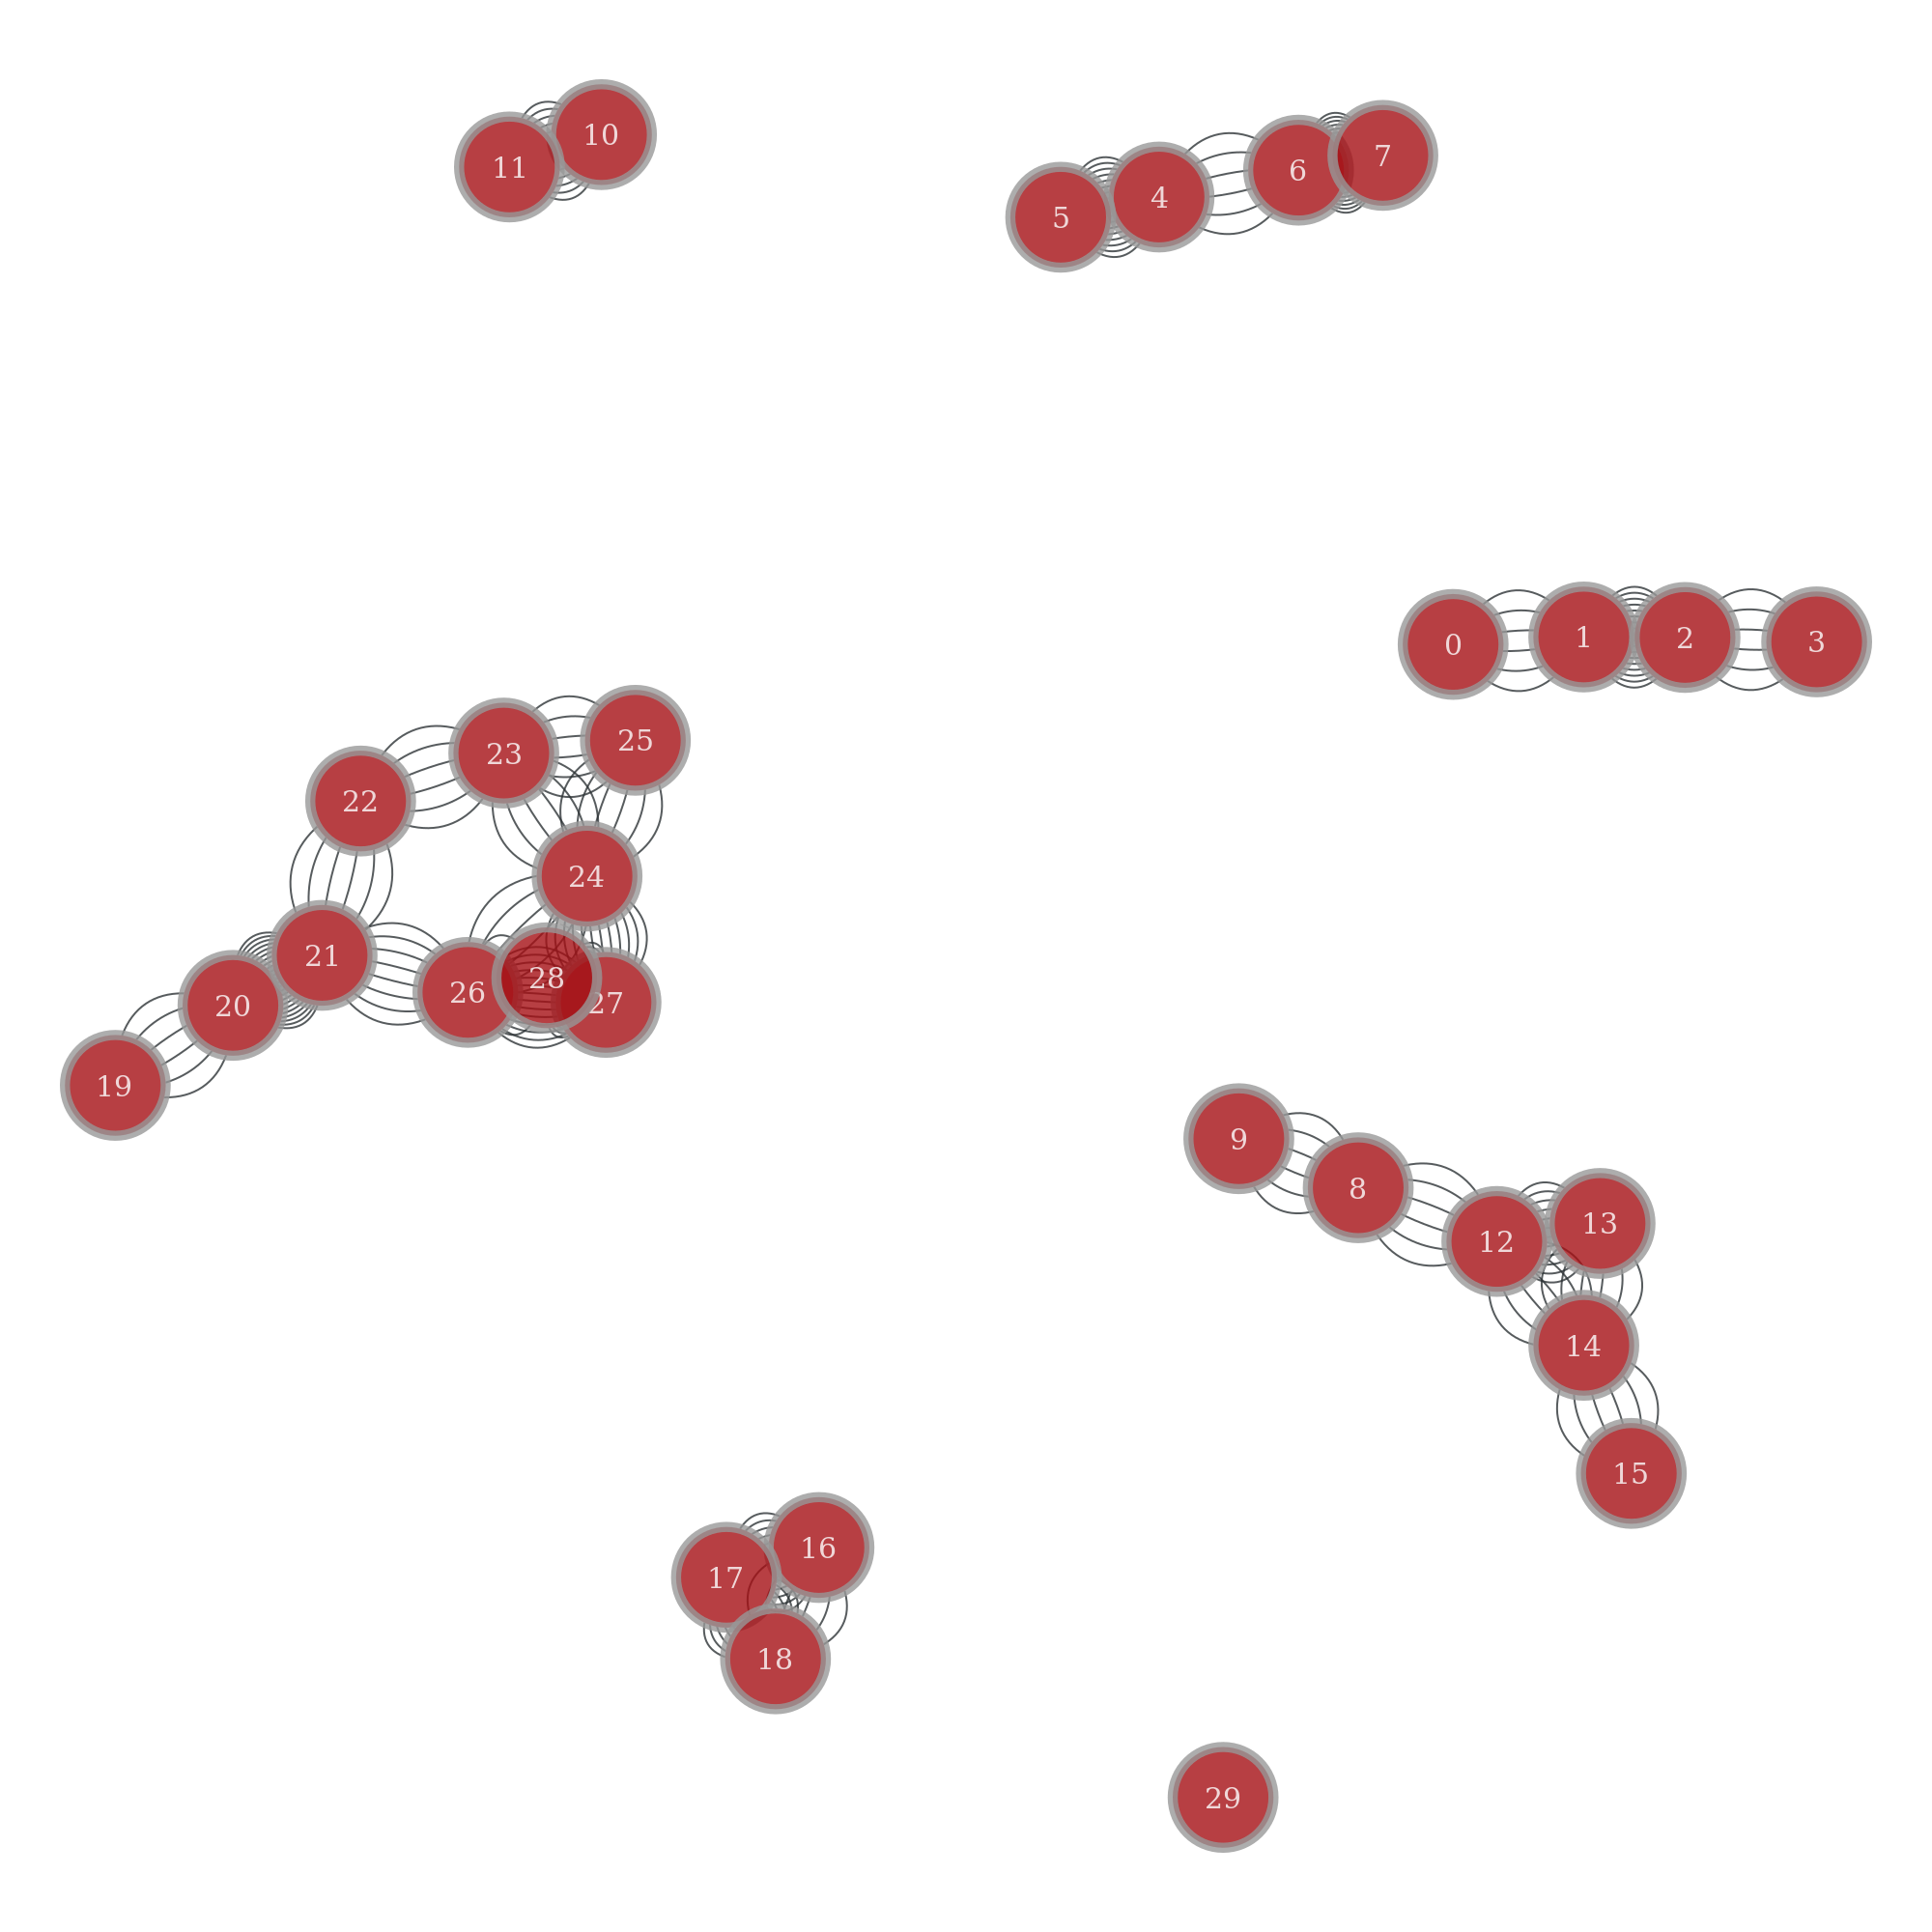

In [153]:
_=random_graph(cell_graph, 30, 120, n_cell_binding=400, n_protein_binding=4, 
               concentration=0.02, reactivity=0.1, mobility=0.05, max_time=5.0)

Hmmm somehow there are many individual clusters... Maybe we can increase the number of networking proteins

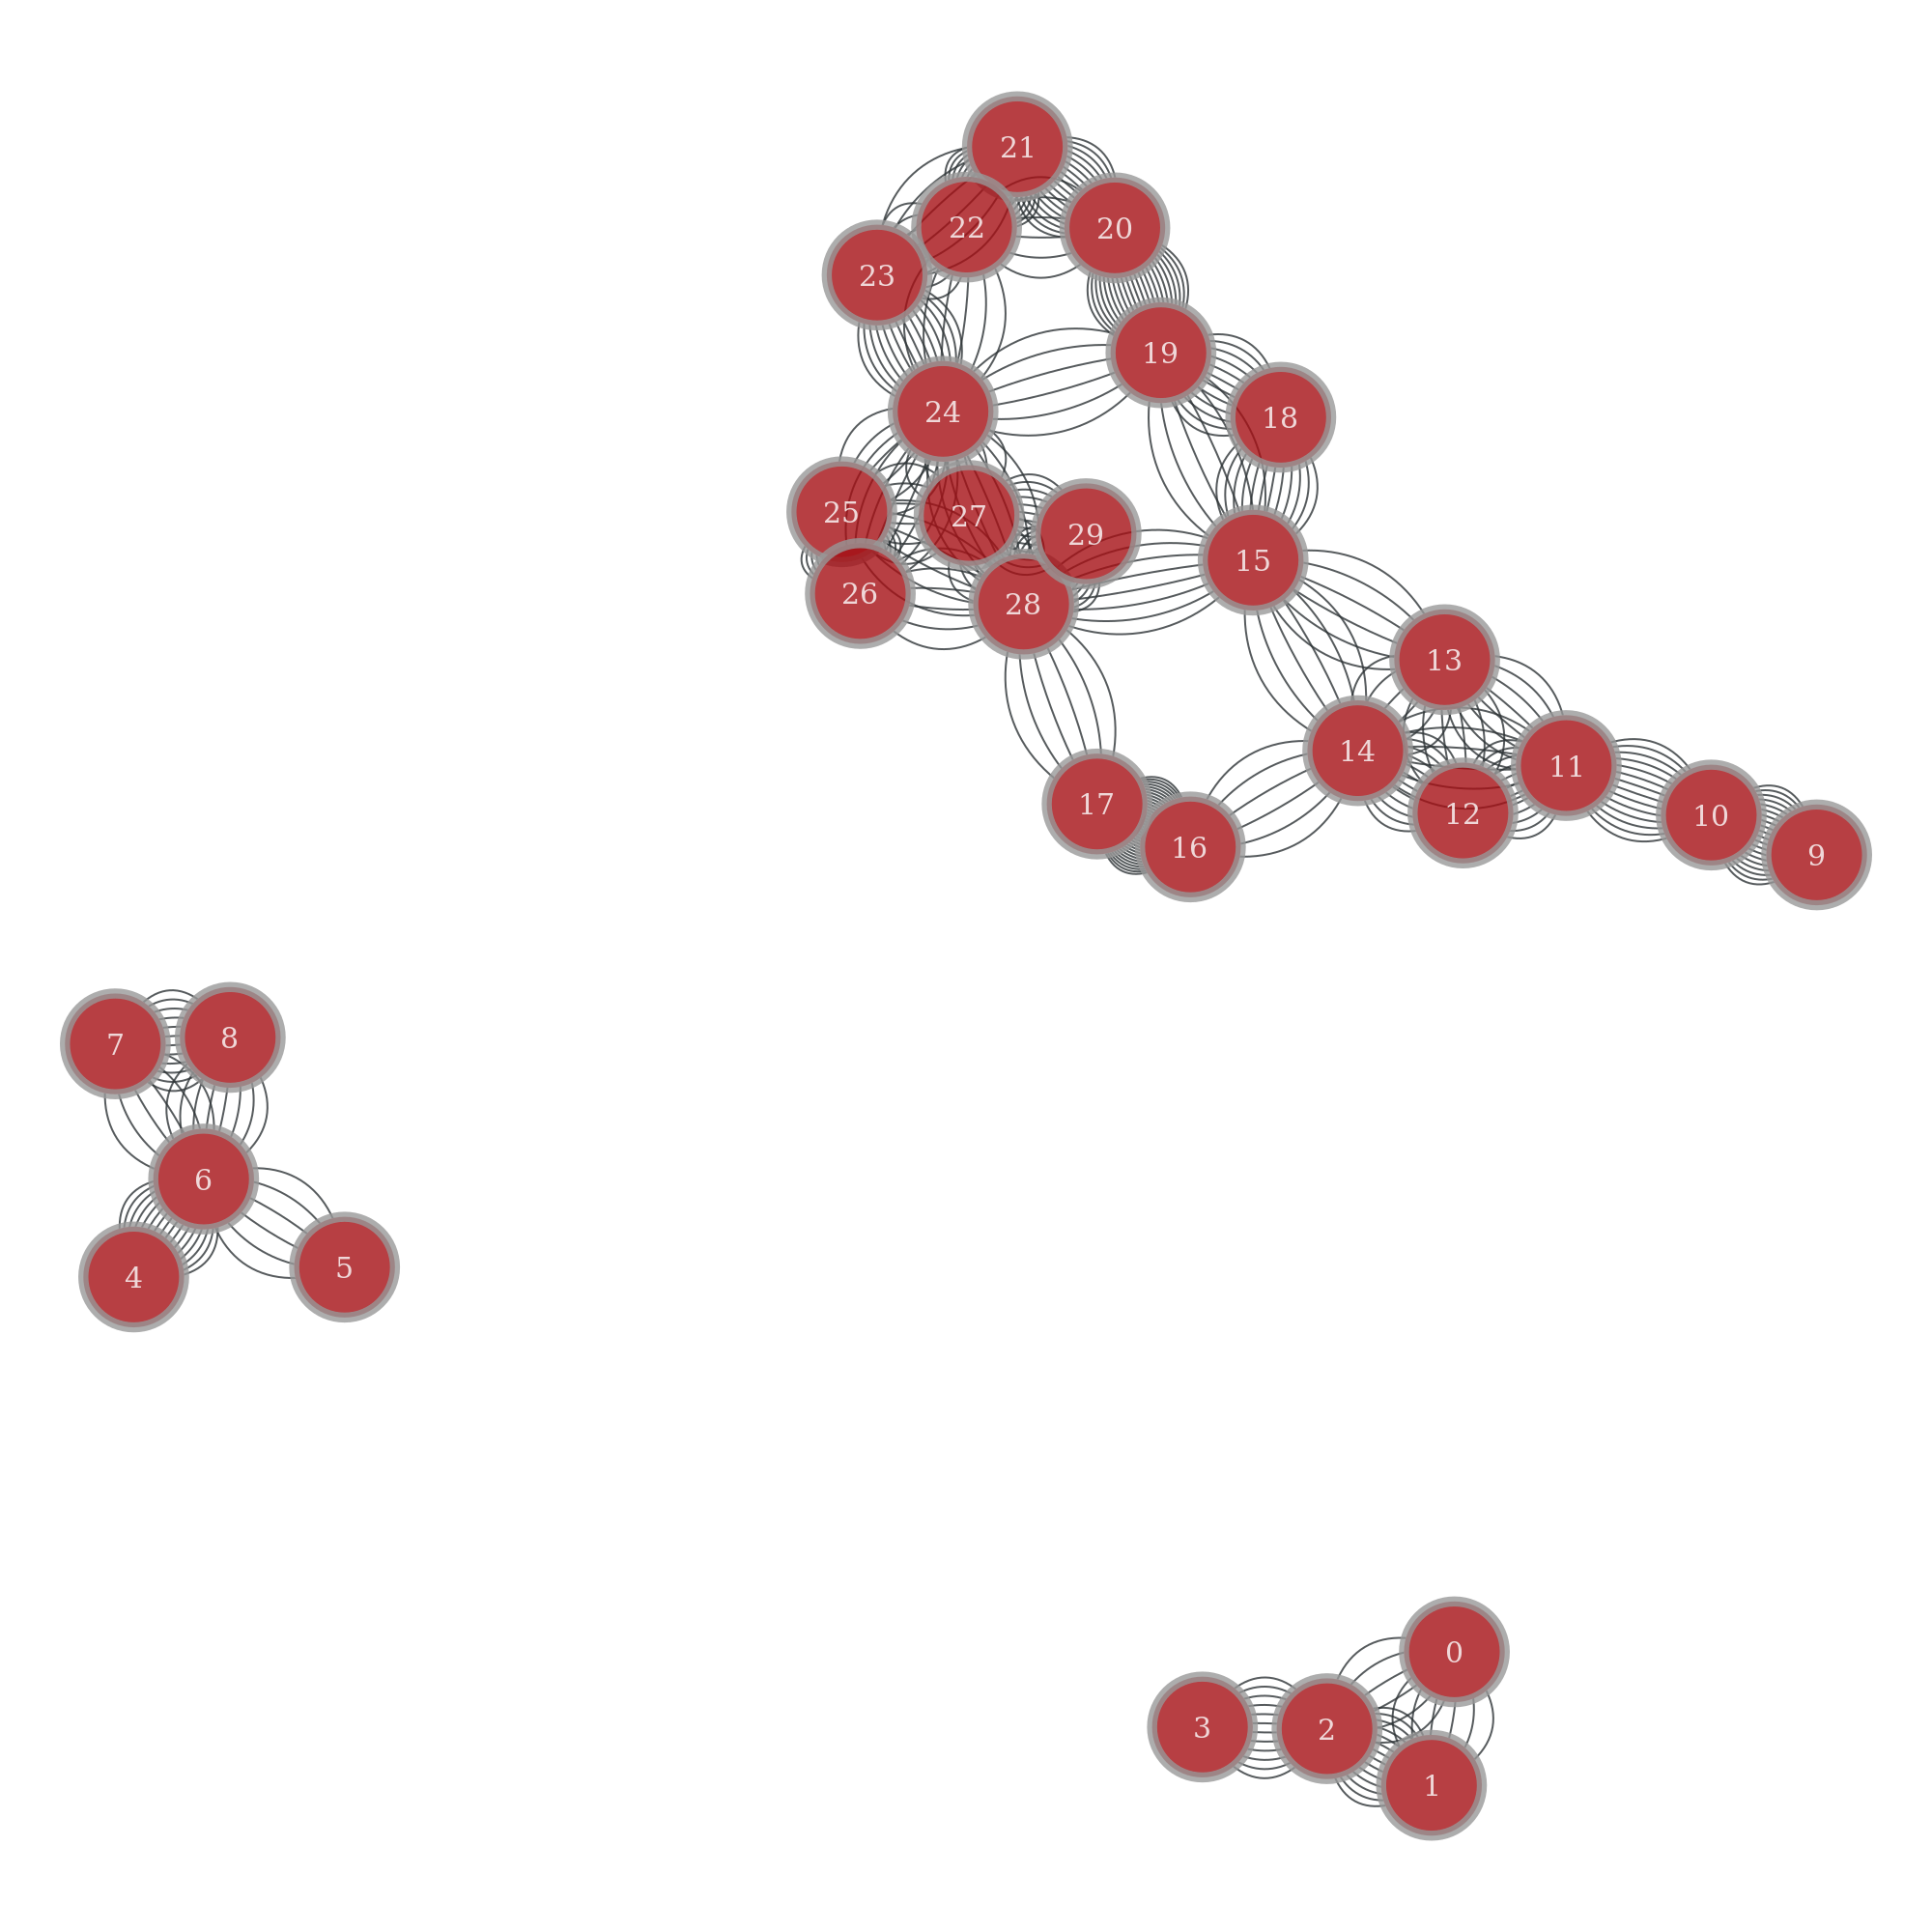

In [154]:
_=random_graph(cell_graph, 30, 200, n_cell_binding=400, n_protein_binding=4, 
               concentration=0.02, reactivity=0.1, mobility=0.05, max_time=5.0)

Ok, that ooks a bit better already. What if we give it a bit more time to react?

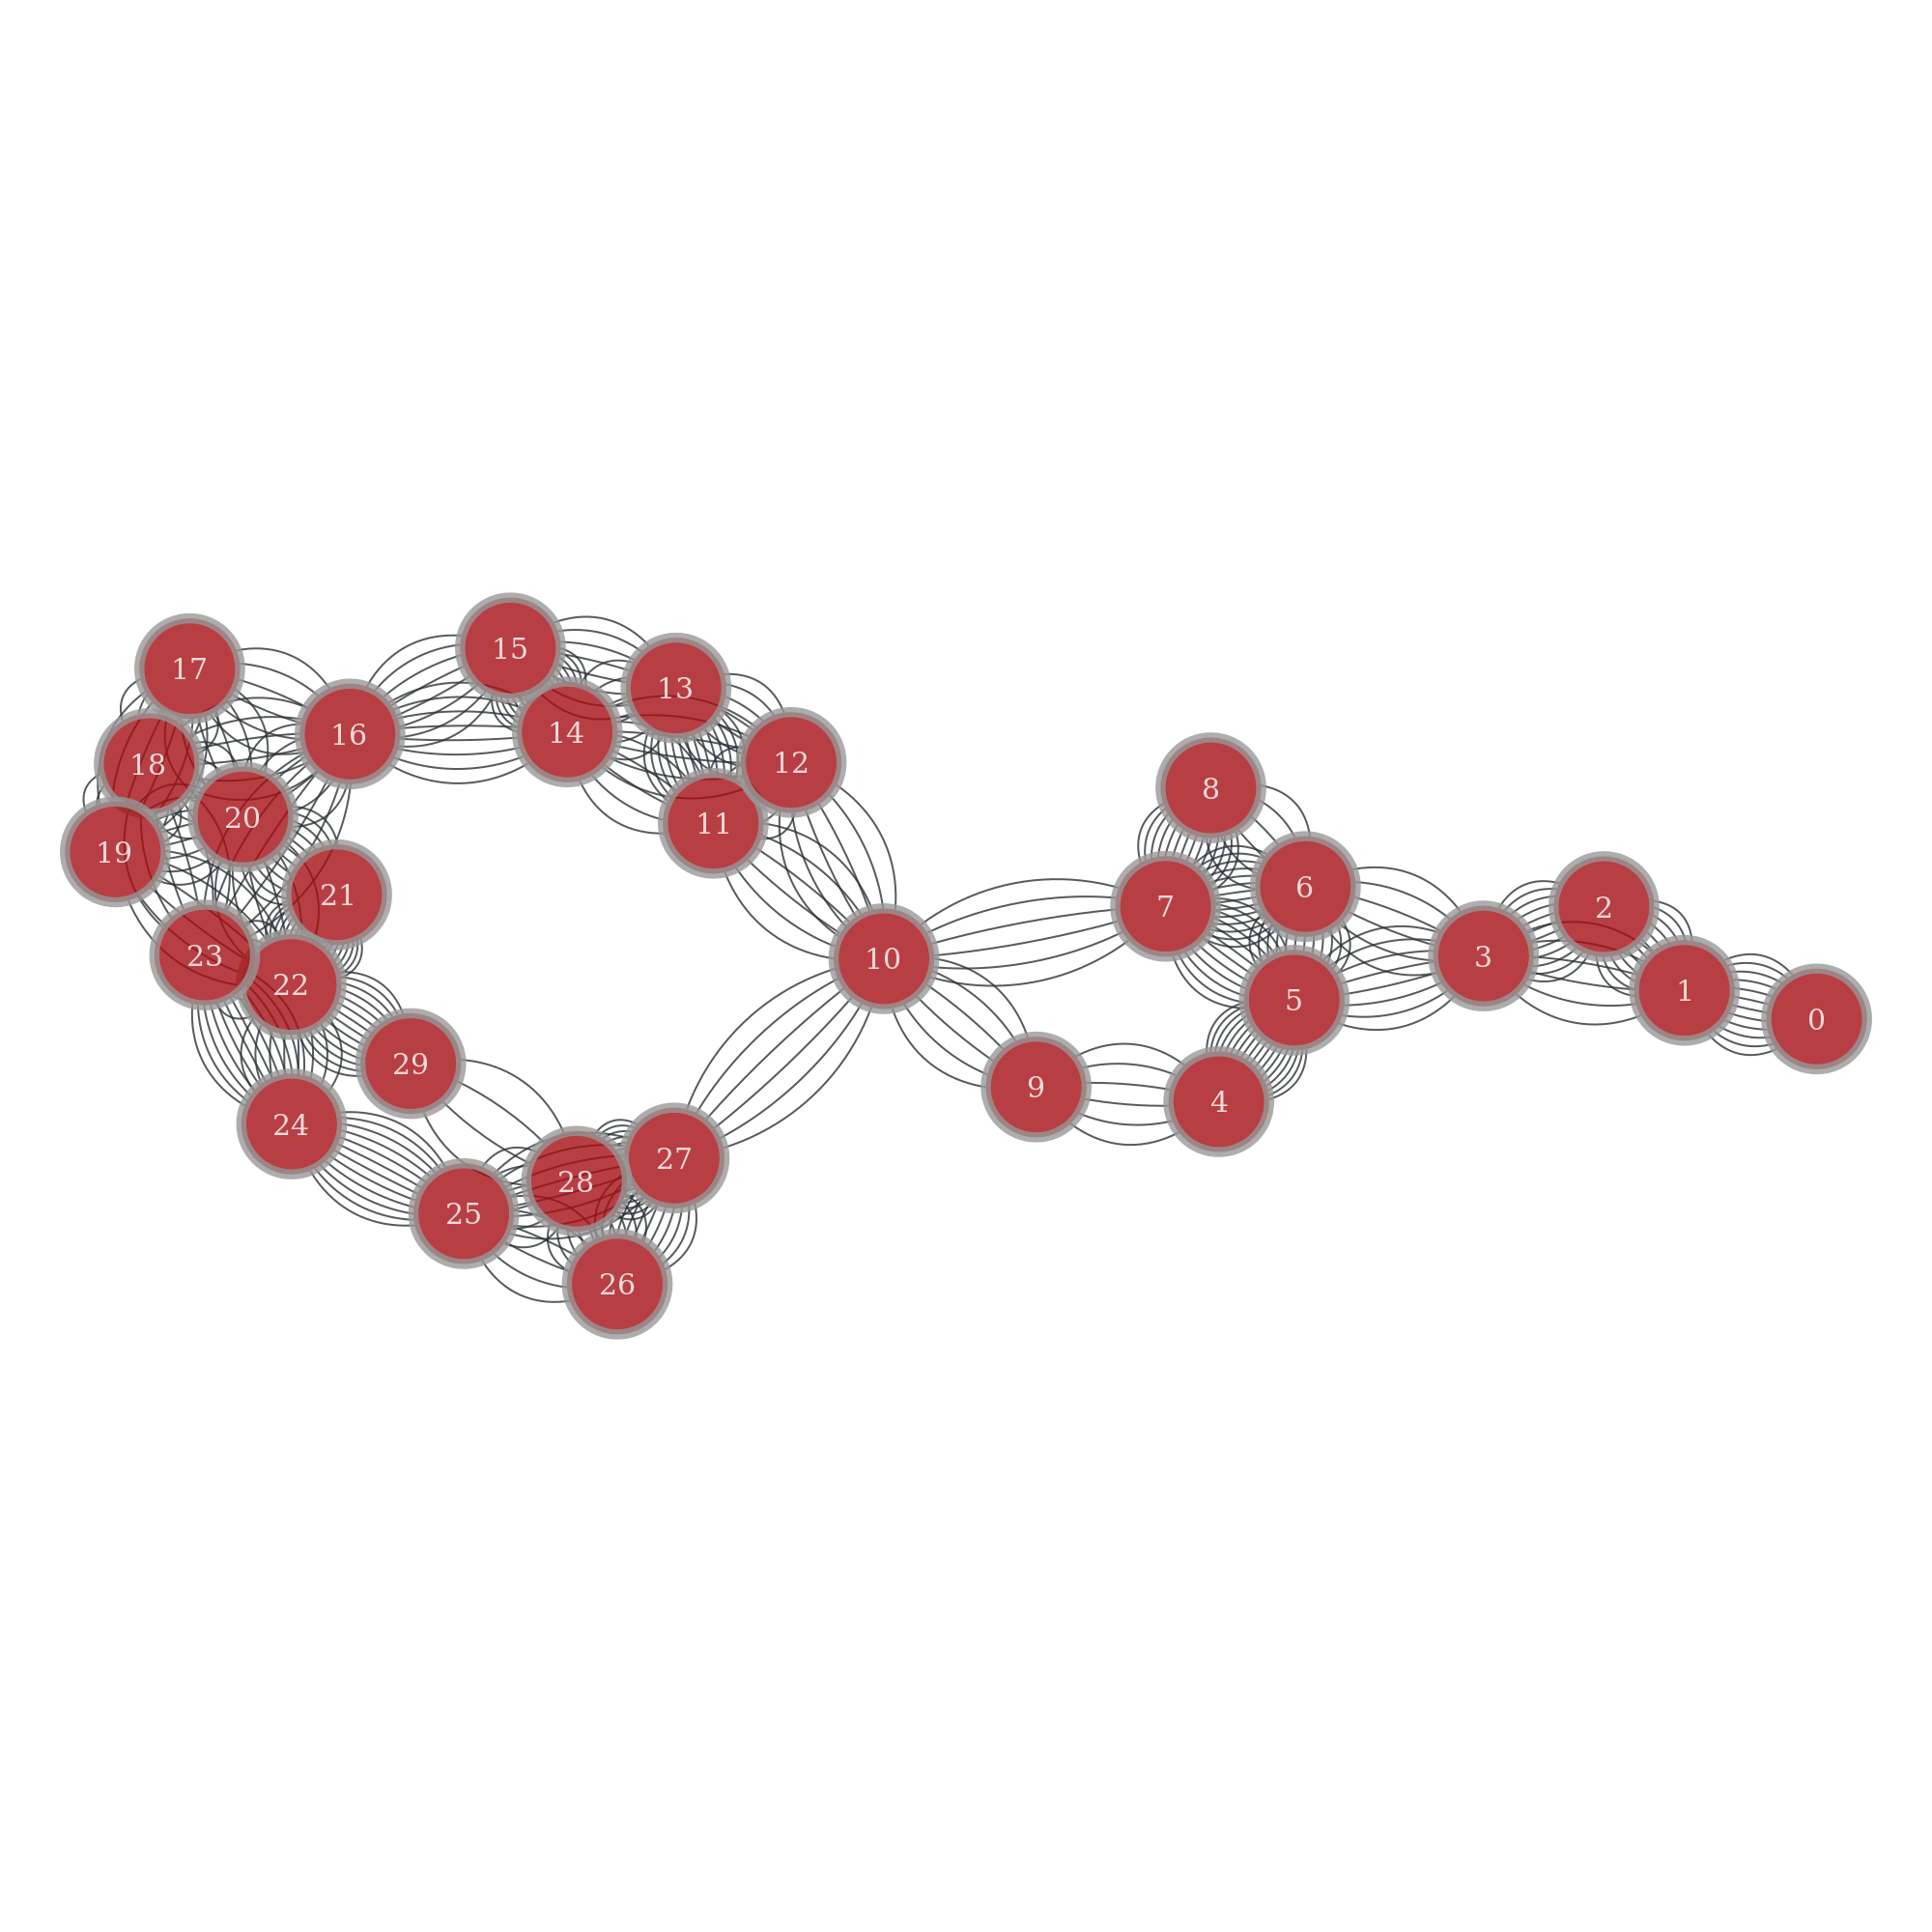

In [155]:
_=random_graph(cell_graph, 30, 200, n_cell_binding=400, n_protein_binding=4, 
               concentration=0.02, reactivity=0.1, mobility=0.05, max_time=10.0)

Great! Now everything is connected!

### Lots of eperiments

But maybe we need the reaction to happen fast. So lets put the simulated time back to 5 and try out a lot of different NP concentrations. 

And using graph theoretical metrics we can maybe find a sweet spot with the perfect amount of protein for a certain amount of cells.

But first let's turn of the drawing

In [156]:
draw = False

In [169]:
results=[]
draw=False
n_cells=30
for n_proteins in np.arange(-1.5,4.0,0.1):
    n_proteins = int(n_cells*10**n_proteins)
    g,cells,proteins = random_graph(cell_graph, n_cells, n_proteins, n_cell_binding=400, n_protein_binding=4,
                                    concentration=0.02, reactivity=0.1, mobility=0.05, max_time=1.0)
    
    global_clustering = clustering.global_clustering(g)[0]
    
    tmp=graph_tool.topology.max_cardinality_matching(g)
    n_max_matching = tmp.count(tmp)
    
    max_shortest_path = graph_tool.topology.pseudo_diameter(g)[0]
    
    tmp=graph_tool.topology.label_largest_component(g)
    biggest_cluster = tmp.get_array().shape[0]
    
    tmp = graph_tool.topology.label_components(g)[1]
    tmp = np.sort(tmp)[::-1]
    n_clusters = len(tmp)
    biggest_cluster = tmp[0]
    mean_cluster = np.mean(tmp)
    
    
    n_free_protein_bindings = 0
    n_free_proteins = 0
    for p in proteins:
        p_free = len(list(p.free_bindings))
        n_free_protein_bindings += p_free
        
        if p_free == len(p.bindings):
            n_free_proteins += 1
    
    n_free_cell_bindings = 0
    n_free_cells = 0
    for c in cells:
        c_free = len(list(c.free_bindings))
        n_free_cell_bindings += c_free
        if c_free == len(c.bindings):
            n_free_cells += 1
    
    results.append([n_proteins, n_free_cells, n_free_cell_bindings, n_free_proteins, n_free_protein_bindings,
                    n_clusters, mean_cluster, biggest_cluster, global_clustering, max_shortest_path])
    print results[-1]
    

[0, 30, 12000, 0, 0, 30, 1.0, 1, nan, 0]
[1, 29, 11996, 0, 0, 30, 1.0, 1, nan, 0]
[1, 29, 11996, 0, 0, 30, 1.0, 1, nan, 0]
[1, 29, 11996, 0, 0, 30, 1.0, 1, nan, 0]
[2, 27, 11992, 0, 0, 29, 1.0344827586206897, 2, 0.0, 1.0]
[3, 25, 11988, 0, 0, 28, 1.0714285714285714, 2, 0.0, 1.0]
[3, 26, 11988, 0, 0, 29, 1.0344827586206897, 2, 0.0, 0]
[4, 25, 11984, 0, 0, 29, 1.0344827586206897, 2, 0.0, 0]
[5, 24, 11980, 0, 0, 29, 1.0344827586206897, 2, 0.0, 0]
[7, 22, 11972, 0, 0, 29, 1.0344827586206897, 2, 0.0, 0]
[9, 21, 11964, 0, 0, 30, 1.0, 1, nan, 0]
[11, 13, 11956, 0, 0, 24, 1.25, 2, 0.0, 0]
[15, 14, 11940, 0, 0, 27, 1.1111111111111112, 3, 0.0, 0]
[18, 6, 11928, 0, 0, 20, 1.5, 3, 0.0, 0]
[23, 10, 11908, 0, 0, 26, 1.1538461538461537, 3, 0.0, 0]
[30, 3, 11880, 0, 0, 18, 1.6666666666666667, 4, 0.0, 0]
[37, 4, 11852, 0, 0, 20, 1.5, 3, 0.0, 0]
[47, 1, 11812, 0, 0, 13, 2.3076923076923075, 5, 0.0, 0]
[59, 0, 11770, 0, 6, 13, 2.3076923076923075, 7, 0.0, 1.0]
[75, 0, 11707, 0, 7, 19, 1.5789473684210527, 6

KeyboardInterrupt: 

In [170]:
results=np.asarray(results).T
n_proteins=results[0]
results=results[1:]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


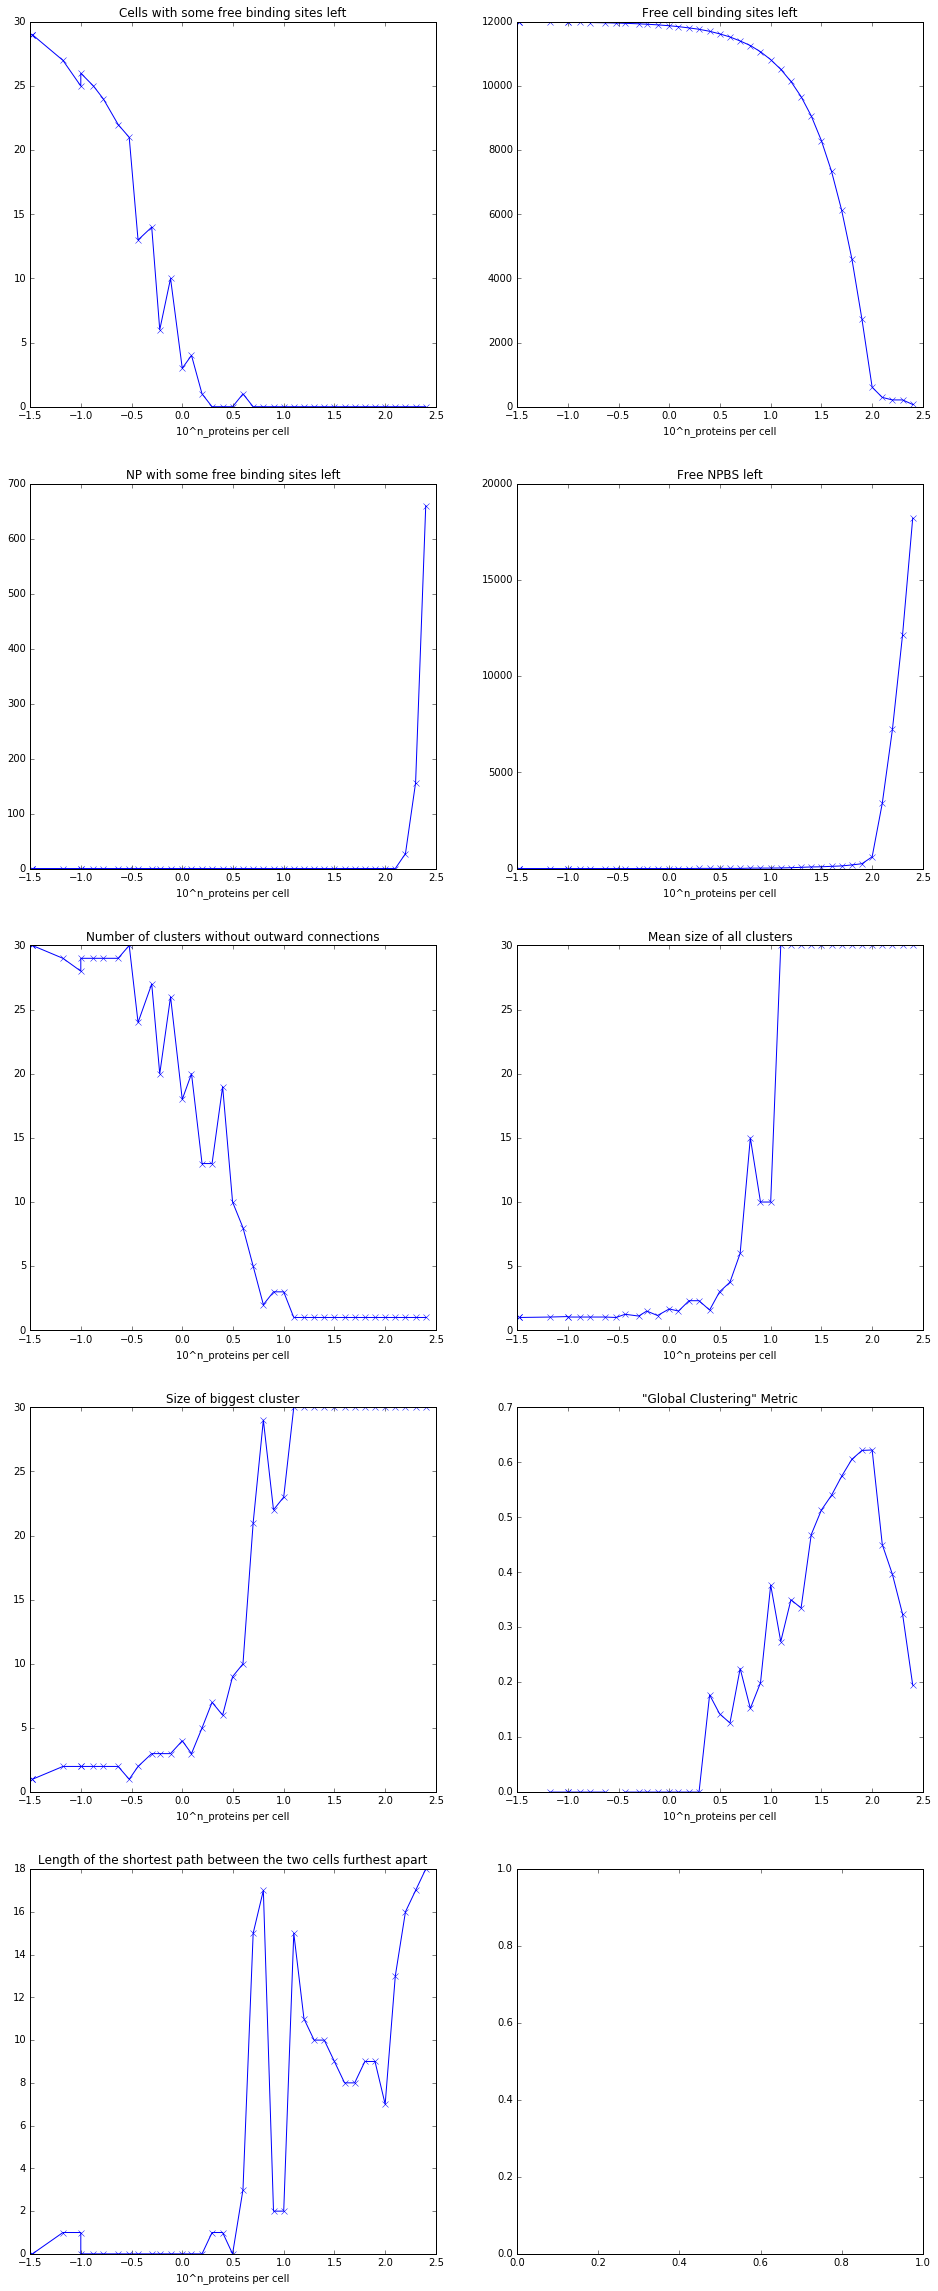

In [177]:
titles=["Cells with some free binding sites left",
        "Free cell binding sites left", 
        "NP with some free binding sites left",
        "Free NPBS left", 
        "Number of clusters without outward connections",
        "Mean size of all clusters",
        "Size of biggest cluster",
        "\"Global Clustering\" Metric",
        "Length of the shortest path between the two cells furthest apart"]
f, axes = plt.subplots(len(titles)/2+1,2, figsize=(16,8*(len(titles)/2+1)))
for i,result in enumerate(results):
    ax = axes[i/2,i%2]
    ax.set_title(titles[i])
    ax.plot(np.log(n_proteins/n_cells)/np.log(10), result.T,"-x")
    #ax.set_xscale("log")
    ax.set_xlabel("10^n_proteins per cell")
    

### Code that is not in use anymore but might be helpful in the future / for others 

In [ ]:
g = Graph(directed=False)

v_size = g.new_vertex_property("int",val=20)
v_group = g.new_vertex_property("int32_t")

#v_color = vprop_vint = g.new_vertex_property("vector<int>", vals=[])

#cell_vertices = list(g.add_vertex(n_cells))
for cell in cells:
    cell.vertex = g.add_vertex()
    v_size[cell.vertex] = 100

for p in proteins:
    last_vertex = None
    for b in p.bindings:
        b.vertex=g.add_vertex()
        v_size[b.vertex] = 10
        v_group[cell.vertex] = p.id

        #intraprotein connections
        if last_vertex is not None:
            g.add_edge(b.vertex,last_vertex)
        last_vertex=b.vertex
        #cell connections
        if b.partner is not None:
            cell_vertex = b.partner.parent.vertex
            g.add_edge(b.vertex,cell_vertex)
            
        
pos=sfdp_layout(g,groups=v_group)
#graph_draw(g, vertex_text=g.vertex_index, vertex_font_size=18, output="/tmp/graph.png",
#            output_size=(2000, 2000))
graph_draw(g, pos=pos,edge_pen_width=2, vertex_text=g.vertex_index, vertex_size=v_size, vertex_font_size=0, output_size=(2000, 2000))
#graphviz_draw(g, elen=100, vsize=v_size, size=(2000, 2000))

In [37]:
stats.distance_histogram(g)

[array([    0.,  4534.,  5366.]), array([0, 1, 2, 3], dtype=uint64)]